![](./images/JN_header.jpg)

# On Shaky Ground - Earthquake Preparedness

**Date:**  12/8/2021

**Author:**  [Ted Brandon](https://github.com/theobigdog)

**Instructor:**  Angelica Spratley

---
## Overview

Most everyone, even those who don't live in prone areas, knows about the awesome, yet devastating power of earthquakes, with caveats of landslides, liquifaction and tsunami. These aspects, combined, form a great threat to human lives, as well as infrastucture, dwellings, businesses, essential utilities such as power and water, etc.  March 11, 2011, a Magnitude(M)-9.0 earthquake off the east coast of Japan caused a tsunami that not only wreaked havoc, as described above, but also led to one of the worst nuclear catastrophies the world has seen. Estimated death count from this event is ~20,000 with roughly \\$220 billion USD in damages in Japan alone.  December 26, 2004, a M-9.1 earthquake off the coast of Sumatra-Andaman caused a tsunami that hit all nearby islands and most nearby countries, including Indonesia, Sri Lanka, India, Maldives and Thailand. This earthquake resulted in the loss of at least 225,000 human lives, and damages of ~\\$15 billion USD.  January 12, 2010, a M-7.0 earthquake in Haiti caused such excessive damage to person and property that, 10 years later, the country has still not recovered.  With an appropriate, predictive model, organizations, such as the Earthquake Disaster Assistance Team (EDAT) can better prepare for these monolithic events.

## Technical Understanding
The nature of the dataset chosen for this project warranted a Time-Series Model.  `Magnitude` was the Target, so this became an analysis of the magnitude of earthquakes over time.  To narrow down the scope, in an attempt to get better results, only Asia was examined, to start.  Fortunately for mankind, there were not, consistently, multiple earthquakes per day, which made it necessary to resample to a monthly mean.  A Dickey-Fuller test was performed on these data which provided a p-value < 0.05, but the “Test Statistic” was slightly greater than the [cutoff](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test_for_stationarity), indicating a lack of stationarity.

A Random Walk was chosen as the First Simple Model (FSM), which provided a train RMSE of M-0.1823, as a baseline.  Next, ARIMA models were manually chosen and evaluated.  Both RMSE values and AIC (Akaike Information Criterion) were calculated for a few “likely” sets of parameters p, d and q.  The set with the most balanced results was (0,1,1).  Based on the Dickey Fuller results, d > 0 was expected, matching well with this set.  ACF and PACF tests were performed, which were difficult to clearly interpret, but appeared to result in q(ACF) and p(PACF) values of 0 or 1, each, again, matching with the manual test.  As seasonality is most always a factor in Time-Series, SARIMA was also investigated.  An automated “optimizer” was performed to check all combinations of p, d, q, P, D and Q with values 0-2.  Results of AIC analysis confirmed that (0,1,1) was the best option, and seasonality was not a factor (0,0,0,12).  During this process, it was determined that when fitting the models, a max_iter of 200 and application of the Nelder-Mead method were necessary.  Data were analyzed using these optimized parameters, resulting in a train/test RMSE of M-0.3074/0.1454, possibly indicating underfitting.  Further testing included SARIMAX to determine the effect(s) of exogenous variables.  This resulted in the conclusion that parameters of (0,1,1)x(0,0,0,12) with the addition of an exogenous variable, consisting of a single array of `Latitude` and `Longitude` values combined, produced the best results with a train/test RMSE of M-0.3111/0.1426.  This was chosen as the final model.  Japan was, individually, similarly examined, using quarterly resampled means, which resulted in a slightly different set of parameters, (1,0,1)x(0,0,0,4) and a train/test RMSE of M-0.1779/0.1885, which represented the best comparison observed for this process.

## Business Understanding

Formed in 2009, the [EDAT](https://www.usgs.gov/natural-hazards/earthquake-hazards/earthquake-disaster-assistance-team-edat) is an international rapid response team under the United States Geological Survey (USGS) umbrella.  The purpose of this study was to provide the EDAT with a valuable, predictive model of future earthquake magnitudes, preferably including information on location (latitude and longitude) as well.  Being an internationally active organization, particular attention need be paid to the Asian continent which, while only comprising 30% of the planet's land surface-area, ~39% of all earthquakes occur here.  Being a relatively small country, Japan, specifically, receives the brunt of ~25% of all earthquakes in Asia and ~9% of all earthquakes, globally.  As an island-nation, Japan is particularly prone not only to earthquakes, but tsunami as well.  With a predictive model of magnitude, relative to location, earthquake preparation can become more robust and impactful, spreading to all countries and continents around the globe.

## Data Understanding

All data come from the Kaggle "Significant Earthquakes, 1965-2016" dataset, which includes the date, time and location of all earthquakes with a magnitude of 5.5 or higher during this time frame. The set contains ~23,000 entries with 21 features(columns), including, in addition to the above, such information as `Type`, `Depth`, `Seismic Stations` and `Magnitude Types`, amongst others.  The target column, `Magnitude` includes the relative strength of each earthquake-entry.  The other features of interest in this dataset include `Latitude`, `Longitude` and `Depth`, with many remaining columns lacking enough information to allow for proper model-development.  I was able to use the features provided for each earthquake to develop a predictive model for future earthquake magnitudes, relative to geographical location, allowing for a better sense of preparedness to be developed.

---

## In the beginning:
Import necessary modules for this analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

Load the data file into a DataFrame and make a new "date-time" object from the appropriate columns.

In [2]:
df = pd.read_csv('data/Significant_Earthquakes_1965-2016.csv')

df['Date_Time'] = df['Date'] + ' ' + df['Time']
df_dt = df.drop('Date', axis=1).drop('Time', axis=1)
dt = df_dt['Date_Time']
df_dt.drop('Date_Time', axis=1, inplace=True)
df_dt = pd.concat([dt, df_dt], axis=1)

#Rows 3378, 7512, 20650 have date-times in a different format, so we'll drop them.
df_dt.drop([3378,7512,20650], inplace=True)

df_dt['Date_Time'] = pd.to_datetime(df_dt['Date_Time'])
df_dt.reset_index(drop=True)
df_dt.head(1)

,Date_Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,Magnitude Error,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,1965-01-02 13:44:18,19.246,145.616,Earthquake,131.6,NaN,NaN,6.0,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic


### EDA Process
Dropped any non-earthquakes, based on the `Type` column.  Once `Type` is cleaned up, every entry in it was "Earthquake", so it was dropped, along with a group of columns that were missing too much data.

In [3]:
df_eq = df_dt[df_dt['Type'] == 'Earthquake'].reset_index(drop=True)

drop_cols = ['Type','Depth Error','Depth Seismic Stations','Magnitude Error','Magnitude Seismic Stations','Azimuthal Gap',\
            'Horizontal Distance','Horizontal Error','Root Mean Square']
df_trim = df_eq.drop(drop_cols, axis=1)
df_trim.head(1)

,Date_Time,Latitude,Longitude,Depth,Magnitude,Magnitude Type,ID,Source,Location Source,Magnitude Source,Status
0,1965-01-02 13:44:18,19.246,145.616,131.6,6.0,MW,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic


#### Summary of Data which will be analyzed:

In [4]:
df_len = len(df)
df_trim_len = len(df_trim)
diff = df_len - df_trim_len
loss = round(diff/df_len*100,2)

print(str(df_len) + ' entries to start.  With cleanup, we now have '
     + str(df_trim_len) + ' remaining.  This is a loss of ' + str(loss) + '%.')

23412 entries to start.  With cleanup, we now have 23229 remaining.  This is a loss of 0.78%.


## Earthquake Map
Need a map of earthquakes to provide a visual representation of these data in the associated presentation.  Commented out to save space.

In [5]:
# df_map = df_trim.copy()
# lat_30 = [-90,-60,-30,0,30,60,90]
# long_30 = [-180,-150,-120,-90,-60,-30,0,30,60,90,120,150,180]

# fig, ax = plt.subplots(figsize=(20,10))
# sns.scatterplot(x=df_map['Longitude'], y=df_map['Latitude'], hue=df_map['Magnitude'],
#                 size=df_map['Magnitude'], sizes=(5,200),marker='o',palette='gnuplot_r')
# # leg_col = '#f7f7f7' # For overlay
# leg_col = 'black' # For notebook
# legend = plt.legend(title='Magnitude', title_fontsize=24, fontsize=20, labelspacing=0.2,
#                 loc=(0.55,0.01), ncol=3, frameon=False, labelcolor=leg_col)
# plt.setp(legend.get_title(), color =leg_col, fontweight='bold')
# ax.set_ylim([-90,90])
# plt.title('Earthquakes: 1965-2016 (Color/Size based on magnitude)', fontsize=36,
#           fontweight='bold', y=1.03)
# plt.xlabel('Longitude', fontsize=24, fontweight='bold')
# plt.yticks(lat_30, fontsize=20)
# ax.set_xlim([-180,180])
# plt.ylabel('Latitude', fontsize=24, fontweight='bold')
# plt.xticks(ticks=(long_30), fontsize=20);
# # plt.savefig('images/earthquake_map_presentation.png', transparent=True, dpi=300) # Export for presentation
# # plt.savefig('images/earthquake_map_notebook.png', dpi=300) # Export for notebook

## Country Names Needed
Since I will eventually pare this down to just Asian countries, then, further, to Japan only, the next two blocks of code were written to identify the country that experienced a given earthquake.  The first step makes a new column, `Geocode`, as a list of tuples of `Latitude` and `Longitude`.  Then `reverseGeocode` and `country_converter` are combined to generate a `Country` column.

The `reverseGeocode` step took about 4hr to complete, so the results were backed-up as a csv.  Future importing of this csv allows for these time-demanding steps to be bypassed.  The code has been commented out to prevent accidental re-processing.

In [6]:
# df_lat_long = df_binned.copy()
# lat_long = []
# for i in range(len(df_lat_long['Latitude'])):
#     lat_long.append((df_lat_long['Latitude'][i], df_lat_long['Longitude'][i]))
# df_lat_long['Geocode'] = lat_long

# # !pip install reverse_geocoder # reverse_geocoder will most likely need to be installed
# import reverse_geocoder as rg
# # !pip install country_converter # country_converter will most likely need to be installed
# import country_converter as coco

# # def reverseGeocode(coordinates):
#    # result = rg.search(coordinates)
#    # return coco.convert(names=result[0]['cc'], to='name_short')

# df_geocode = df_lat_long.copy()
# df_geocode['Country'] = df_geocode['Geocode'].apply(reverseGeocode)

# df_geocode.to_csv('data/official_countries.csv')

In [7]:
df_countries = pd.read_csv('data/official_countries.csv')

### Identifying Earthquakes from Asia:
Now that I had a country associated with each entry, a subset dataframe was generated, including only [asian countries](https://www.countries-ofthe-world.com/countries-of-asia.html).  A simple function was created to generate a new feature in the dataframe, identifying each country as either Asian(1) or not Asian(0):

In [8]:
def is_asian(country):
    asia = ['Afghanistan','Armenia','Azerbaijan','Bahrain','Bangladesh','Bhutan','Brunei',
           'Cambodia','China','Cyprus','Georgia','India','Indonesia','Iran','Iraq','Israel',
           'Japan','Jordan','Kazakhstan','Kuwait','Kyrgyzstan','Laos','Lebanon','Malaysia',
           'Maldives','Mongolia','Myanmar','Nepal','North Korea','Oman','Pakistan','Palestine',
           'Philippines','Qatar','Russia','Saudi Arabia','Singapore','South Korea','Sri Lanka',
           'Syria','Taiwan','Tajikistan','Thailand','Timor-Leste','Turkey','Turkmenistan','UAE',
           'United Arab Emirates','United Arab Emirates (UAE)','Uzbekistan','Vietnam','Yemen']
    if country in asia:
        asian = 1
    else:
        asian = 0
    return asian

df_countries['In_Asia'] = df_countries['Country'].apply(is_asian)

The new feature allows for the creation of a new dataframe, containing solely Asian countries:

In [9]:
total_earthquakes = len(df_countries)
asian_earthquakes = df_countries['In_Asia'].value_counts()[1]
non_asian_earthquakes = df_countries['In_Asia'].value_counts()[0]
percent_asian = round(df_countries['In_Asia'].value_counts('1')[1] * 100, 2)

print('There are ' + str(total_earthquakes) + ' earthquakes in the initial data set.')
print(str(asian_earthquakes) + ' of these occurred in Asian countries,')
print('leaving ' + str(non_asian_earthquakes) + ' occurring in the rest of the world.')
print('This means that earthquakes in Asia accounted for ' + str(percent_asian) + '% of the\
 world total from 1965 through 2016.')

There are 23229 earthquakes in the initial data set.
8859 of these occurred in Asian countries,
leaving 14370 occurring in the rest of the world.
This means that earthquakes in Asia accounted for 38.14% of the world total from 1965 through 2016.


In [10]:
df_asian = df_countries[df_countries['In_Asia'] == 1].reset_index(drop=True)
drop_extra = ['Unnamed: 0']
df_asian = df_asian.drop(drop_extra, axis=1)
# Somehow the Date_Time column was changed back to an "object" so it was fixed here
df_asian['Date_Time'] = pd.to_datetime(df_asian['Date_Time']).reset_index(drop=True)

Exported the DataFrame of asian earthquakes to be used for Japan analysis down the line. Commented out to prevent accidental overwriting.

In [11]:
# df_asian.to_csv('data/asia_df.csv')

Another plot, this time solely of Asian earthquakes, is necessary for the presentation as well, commented out to save space.

In [12]:
# fig, ax = plt.subplots(figsize=(20,10))
# sns.scatterplot(x=df_asian['Longitude'], y=df_asian['Latitude'], hue=df_asian['Magnitude'],
#                 size=df_asian['Magnitude'], sizes=(5,200),marker='o',palette='gnuplot_r')
# # leg_col = '#f7f7f7' # For overlay
# leg_col = 'black' # For notebook
# legend = plt.legend(title='Magnitude', title_fontsize=24, fontsize=20, labelspacing=0.2,
#                 loc=(0.55,0.01), ncol=3, frameon=False, labelcolor=leg_col)
# plt.setp(legend.get_title(), color =leg_col, fontweight='bold')
# ax.set_ylim([-90,90])
# plt.title('Asian Earthquakes: 1965-2016 (Color/Size based on magnitude)', fontsize=36,
#           fontweight='bold', y=1.03)
# plt.xlabel('Longitude', fontsize=24, fontweight='bold')
# plt.yticks(lat_30, fontsize=20)
# ax.set_xlim([-180,180])
# plt.ylabel('Latitude', fontsize=24, fontweight='bold')
# plt.xticks(ticks=(long_30), fontsize=20);
# # plt.savefig('images/asian_earthquake_map_presentation.png', transparent=True, dpi=300) # Export for presentation
# # plt.savefig('images/asian_earthquake_map_notebook.png', dpi=300) # Export for notebook

---
## The Time-Series Modeling Process
First, a time-series must be created.  I started with `Magnitude`, as, this is my target.  A monthly mean was necessary for calculations down the line.  A visualization will help get a feel for how the data look:

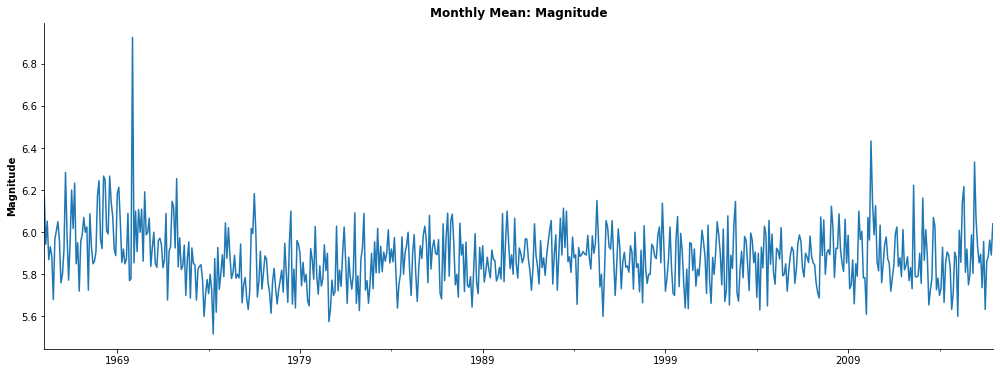

In [13]:
asian_ts = pd.Series(df_asian.set_index(df_asian['Date_Time'])['Magnitude'])
monthly_mean_asian = asian_ts.resample('MS').mean()

fig, ax = plt.subplots(figsize=(17,6))
monthly_mean_asian.plot()
ax.set_title('Monthly Mean: Magnitude', fontweight='bold')
ax.set_ylabel('Magnitude',fontweight='bold')
ax.set_xlabel('',fontweight='bold')
sns.despine(top=True,right=True);

Looking at the plot of the monthly mean doesn't provide a ton of information, but it does look fairly stationary.  I made and ran a function for a Dickey-Fuller test to make sure.
#### Dickey-Fuller Function:

In [14]:
def run_df(ts):
    df_rslt = adfuller(ts)
    print("Dickey_Fuller test results:  \n")
    df_output = pd.Series(df_rslt[0:4], index=['Test Statistic','p-value',\
                                              '#Lags Used','Number of Observations Used'])
    for key, value in df_rslt[4].items():
        df_output['Critical Value (%s)'%key] = value
    print(df_output)
    print()
    if df_output['p-value'] < 0.05 and df_output['Test Statistic'] < -3.43: # -3.43 was the best I could find, on Wikipedia
        print('With ', len(ts), ' data points, a p-value of ', round(df_output['p-value'],7),'(<0.05) and a DFt of ',
              round(df_output['Test Statistic'],3),', the Null Hypothesis can be rejected and there appears to be stationarity.')
    elif df_output['p-value'] >= 0.05:
        print('p-value greater than 0.05:  ', df_output['p-value'])
    else:
        print('Failed to reject the Null Hypothesis and there appears to be a lack of stationarity.')

In [15]:
run_df(monthly_mean_asian)

Dickey_Fuller test results:  

Test Statistic                  -3.110476
p-value                          0.025788
#Lags Used                      18.000000
Number of Observations Used    605.000000
Critical Value (1%)             -3.441205
Critical Value (5%)             -2.866329
Critical Value (10%)            -2.569320
dtype: float64

Failed to reject the Null Hypothesis and there appears to be a lack of stationarity.


Apparently, the series isn't stationary after all.  We may need to account for this.  We'll see.

### Train/Test Split:
For time-series, random sampling doesn't work; data must be continuous.  Therefore, the chronological first 80% of the time-series was defined as the train, with the remaining 20% defined as the test.

In [16]:
cutoff = round(monthly_mean_asian.shape[0] * 0.8)
train = monthly_mean_asian[:cutoff]
test = monthly_mean_asian[cutoff:]

### Random Walk:
The random walk is just a shift in the time-series by 1 unit.  In this case, the unit was 1 month.  This process indicates that the best fit is to base each day from the previous.  This was done, and a plot generated (for the presentation), showing the final 10 years-worth of data from the train set.

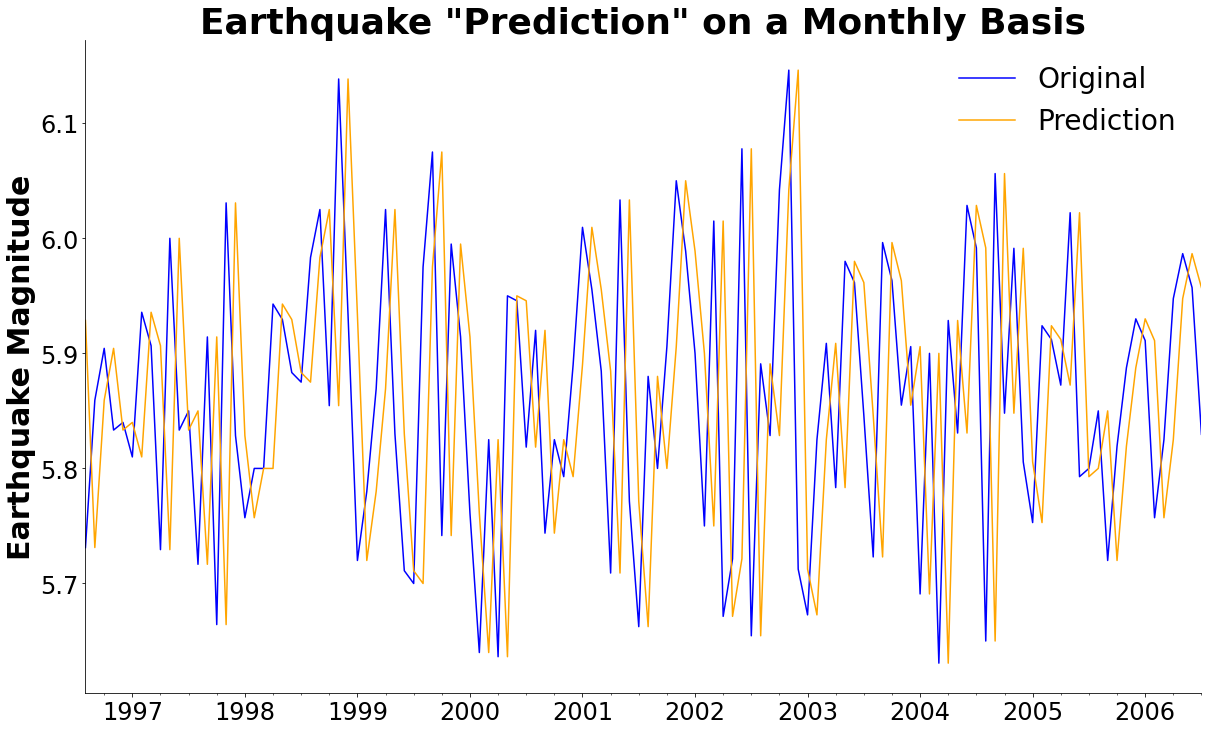

In [17]:
random_walk = train.shift(1)

fig, ax = plt.subplots(figsize=(20,12))
train[-120:].plot(ax=ax, c='blue', label='Original')
random_walk[-120:].plot(ax=ax, c='orange', label='Prediction')
ax.set_title('Earthquake "Prediction" on a Monthly Basis', fontsize=36, fontweight='bold')
sns.despine(right=True,top=True)
plt.ylabel('Earthquake Magnitude', fontsize=30, fontweight='bold')
plt.yticks(fontsize=24)
plt.xlabel('')
plt.xticks(fontsize=24)
ax.legend(fontsize=28,loc='best', frameon=False);
# plt.savefig('images/random_walk.png', dpi=300)

### Root Mean Squared Error (RMSE): My metric for determining model quality
---
The results of RMSE calculations were used for all comparisons in this project.  The calculation is straightforward, using functions built into NumPy.  In the case of a random walk, the first entry of the train must be ignored because it has no counter-part in the RW results.  Therefore, I used [1:] as my range.

In [18]:
rmse_rw = np.sqrt(mean_squared_error(train.dropna()[1:], random_walk.dropna()))
print('Random Walk RMSE (Baseline):',round(rmse_rw,4))

Random Walk RMSE (Baseline): 0.1823


### ARIMA - Autoregressive(AR) Integrated(I) Moving Average(MA) - Model
---
The ARIMA model also predicts future values, based on past values, but in a more sophisticated way than with a RW.  This model has 3 hyper-parameters (p,d,q) which are related to the different components of the model (AR-**p**, I-**d**, MA-**q**).  Since I(d) is related to the stationarity of the data, I started there, generating the "equivalent" of a random walk.  Because many RMSE's will be calculated throughout this process, a short function was written to make future calculations a little quicker.  I also ended up needed an altered RMSE function for the "test" values, so that has been included here too.

In [19]:
def RMSE(ts,mod):
    y_hat = mod.predict(typ='levels')
    return np.sqrt(mean_squared_error(ts,y_hat))
def RMSE_test(ts,mod,exo=None):
    y_hat = mod.predict(start=ts.index[0],end=ts.index[-1],exog=exo,typ='levels')
    return np.sqrt(mean_squared_error(ts,y_hat))

In [20]:
rw = ARIMA(train, order=(0,1,0)).fit()
rw_rmse = RMSE(train,rw)

Some further experimenting will help me get a feel for the necessary parameters for this model.  Comparing both RMSE values, and model-associated Akaike Information Criteria (AIC) values will determine which is "best".  The AIC quantifies both the goodness of the fit and the simplicity of the model into a single, comparable statistic, with lower values being "better".  In this case, while low AIC is the predictor of the "best" model, RMSE is best at prediction, which is the goal of this project, so RMSE will be the preferred metric.

In [21]:
ar = ARIMA(train, order=(1,0,0)).fit()
ar_rmse=RMSE(train,ar)

ari1 = ARIMA(train, order=(1,1,0)).fit()
ari1_rmse = RMSE(train,ari1)

ari2 = ARIMA(train, order=(2,1,0)).fit()
ari2_rmse = RMSE(train,ari2)

ma = ARIMA(train, order=(0,0,1)).fit()
ma_rmse = RMSE(train,ma)

ima1 = ARIMA(train, order=(0,1,1)).fit()
ima1_rmse = RMSE(train,ima1)

ima2 = ARIMA(train, order=(0,1,2)).fit()
ima2_rmse = RMSE(train,ima2)

arima = ARIMA(train, order=(1,1,1)).fit()
arima_rmse = RMSE(train,arima)

arima_name_list = ['RW RMSE:','AR RMSE:','ARI1 RMSE:','ARI2 RMSE:','MA RMSE:','IMA1 RMSE:','IMA2 RMSE:','ARIMA RMSE:']
arima_list = [rw_rmse,ar_rmse,ari1_rmse,ari2_rmse,ma_rmse,ima1_rmse,ima2_rmse,arima_rmse]
mod_list = [rw,ar,ari1,ari2,ma,ima1,ima2,arima]

for mod in range(len(arima_list)):
    print(arima_name_list[mod], round(arima_list[mod],4),' AIC:', round(mod_list[mod].aic,3))

RW RMSE: 0.3313  AIC: -280.065
AR RMSE: 0.1396  AIC: -543.371
ARI1 RMSE: 0.3193  AIC: -412.07
ARI2 RMSE: 0.3153  AIC: -462.534
MA RMSE: 0.1399  AIC: -540.552
IMA1 RMSE: 0.3075  AIC: -585.472
IMA2 RMSE: 0.3075  AIC: -583.491
ARIMA RMSE: 0.3075  AIC: -583.49


These results provided conflicting conclusions.  On one hand, AR (1,0,0) produced the lowest RMSE, but only a (comparatively) moderately low AIC, while both IMA1 (0,1,1) and ARIMA (1,1,1) produced the lowest AIC, but fairly high RMSE values.  Based on my criterion, AR is the "best" model, but these conflicting results indicated that delving further into these models would be prudent.

### ACF and PACF
Partial Auto-Correlation Function (PACF) is useful for determining the "p" parameter for AR.  Where the residual-lag value (p) equilibrates into the confidence bands, the optimal value can be determined.  (Complete) Auto-Correlation Function (ACF) helps determine the "q" parameter for MA, using lags similarly to the PACF process.

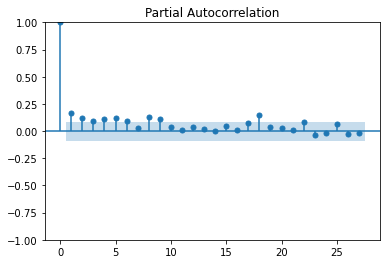

In [22]:
plot_pacf(train,method='ywm'); # default "method=(ym)" can produce values outside [-1,1] so ywm used instead

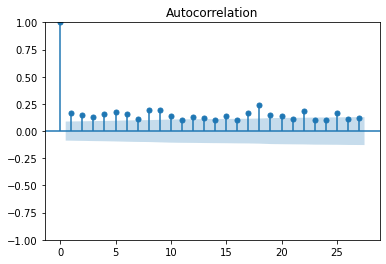

In [23]:
plot_acf(train);

The PACF plot shows that the "p" parameter will most likely be optimized at 1, possibly even 0.  The acf is a little bit more difficult to interpret, but the likely optimized value is 0.  This conclusion does match well with the previous calculations of RMSE and AIC for the "AR" model (1,0,0).  There is an easier, though somewhat time-consuming, way to determine optimal values for p, d and q.

### Automated "optimizer" for SARIMA selecting parameters p, d, q and P, D, Q
Much like the ARIMA process above, SARIMA models are necessary when there is Seasonality present in the time-series.  The seasonality componenet has it's own P, D, Q hyperparameters, which must be optimized similarly to the above.  An automated process to determine this, based on AIC values, follows

First, develop a list of parameters to test:

In [24]:
p = d = q = range(0,3) # This will test all variations of the three parameters using values 0-2
pdq = list(itertools.product(p,d,q))
# This will test all variation of the 3 seasonal parameters.  12 indicates the number of months in a year
seasonal_pdq = [(x[0],x[1],x[2],12) for x in list(itertools.product(p,d,q))]
print('Examples of parameters for SARIMA:')
print('SARIMAX: {} x {}'.format(pdq[0],seasonal_pdq[0]))
print('SARIMAX: {} x {}'.format(pdq[10],seasonal_pdq[13]))
print('SARIMAX: {} x {}'.format(pdq[-1],seasonal_pdq[-1]))

Examples of parameters for SARIMA:
SARIMAX: (0, 0, 0) x (0, 0, 0, 12)
SARIMAX: (1, 0, 1) x (1, 1, 1, 12)
SARIMAX: (2, 2, 2) x (2, 2, 2, 12)


Testing all the possible combinations of 0, 1 and 2 for these 6 parameters (12 stays constant, as it represents the number of months):
#### *This only needed to be run one time.  It takes a while, so a dictionary was created, converted to a dataframe, and saved as a csv for future importing.  It is commented out to prevent this long list of calculations from being run again, unnecessarily.

In [25]:
# SARIMAX_dict1 = {'stats':[],'aic':[]} # Dictionary mackes it easy to look through results when finished
# for param in pdq:  # Only run again if we need to re-optimize
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod=SARIMAX(train,
#                          order=param,
#                          seasonal_order=param_seasonal,
#                          enforce_stationarity=False,
#                          enforce_invertibility=False)
#             results = mod.fit()
#             SARIMAX_dict1['stats'].append('ARIMA{}x{}'.format(param,param_seasonal))
#             SARIMAX_dict1['aic'].append(results.aic)
#             print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
#         except: 
#             print('Oops!')
#             continue
# df_sar = pd.DataFrame(SARIMAX_dict1)
# df_sar.to_csv('data/SARIMAX_dict1.csv')

The "best" (lowest calculated AIC) paramters can be determined quickly by examining the dictionary created above.  The "Top 4" options are printed below:

In [26]:
df_sarima = pd.read_csv('data/SARIMAX_dict1.csv')
df_sarima.sort_values('aic').head(4)

,Unnamed: 0,stats,aic
108,108,"ARIMA(0, 1, 1)x(0, 0, 0, 12)",-585.052785
270,270,"ARIMA(1, 0, 1)x(0, 0, 0, 12)",-584.439852
351,351,"ARIMA(1, 1, 1)x(0, 0, 0, 12)",-583.062379
513,513,"ARIMA(2, 0, 1)x(0, 0, 0, 12)",-582.109932


All 4 of these options showed zero seasonality ((P,D,Q,Months) = (0,0,0,12)), so there is no seasonal pattern to earthquakes from this dataset.

### Testing "Optimized" SARIMA Models
Unsurprisingly, some of the best calculated parameters were equivalent to those determined earlier by hand.  Models were made of a few of them to see how well they performed.

(0,1,1),(0,0,0,12) RMSE:
train:   0.3074
test:  0.1454


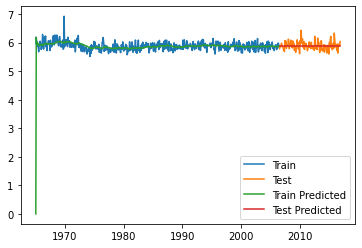

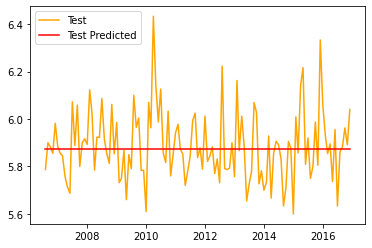

                               SARIMAX Results                                
Dep. Variable:              Magnitude   No. Observations:                  499
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 294.526
Date:                Wed, 08 Dec 2021   AIC                           -585.053
Time:                        06:47:17   BIC                           -576.640
Sample:                    01-01-1965   HQIC                          -581.750
                         - 07-01-2006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9336      0.016    -57.057      0.000      -0.966      -0.902
sigma2         0.0178      0.001     27.070      0.000       0.017       0.019
Ljung-Box (L1) (Q):                   0.01   Jarque-

In [27]:
sari_mod = SARIMAX(train,
                  order=(0,1,1),
                  seasonal_order=(0, 0, 0, 12),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

y_hat_train = sari_mod.predict(typ='levels')
y_hat_test = sari_mod.predict(start=test.index[0], end=test.index[-1],typ='levels')
rmse_011_train = np.sqrt(mean_squared_error(train,y_hat_train))
rmse_011_test = np.sqrt(mean_squared_error(test,y_hat_test))
print('(0,1,1),(0,0,0,12) RMSE:')
print('train:  ',round(rmse_011_train,4))
print('test: ',round(rmse_011_test,4))

fig, ax = plt.subplots()
ax.plot(train, label='Train')
ax.plot(test, label='Test')
ax.plot(y_hat_train, label='Train Predicted')
ax.plot(y_hat_test, label='Test Predicted')
plt.legend();

fig, ax = plt.subplots()
ax.plot(test, label='Test',c='orange')
ax.plot(y_hat_test, label='Test Predicted',c='red')
plt.legend()
plt.show();

print(sari_mod.summary())

It seemed strange that the test RMSE (0.1454) was so much better than the train RMSE (0.3074).  Was the model under-fitting?  It really didn't seem to be.  The p-value was < 0.05 so the results are significant.  I "let it ride", and looked at a few others, each of which showed the same phenomenon:

In [28]:
# This function creates all future SARIMAX models, keeping the code a little shorter and cleaner
def fit_mod(endo, ordr, exo=None, season=(0,0,0,12)):
    return SARIMAX(endog=endo,exog=exo,order=ordr,seasonal_order=season,enforce_stationarity=False,
                   enforce_invertibility=False).fit(maxiter=200,method='nm',disp=False)

In [29]:
trial_models = [(1,0,1),(1,1,1),(2,0,1)]
for trial in trial_models:
    model = fit_mod(train,trial)
    print(str(trial),'RMSE:\n','train:',round(RMSE(train,model),4),'\n','test:',round(RMSE_test(test,model),4),'\n')

(1, 0, 1) RMSE:
 train: 0.3074 
 test: 0.1471 

(1, 1, 1) RMSE:
 train: 0.3074 
 test: 0.1454 

(2, 0, 1) RMSE:
 train: 0.3075 
 test: 0.1472 



For future calculations, I defined the best order for this process:

In [30]:
best_order = (0,1,1)

### Forecasting
All four of these models produced incredibly similar results with the train and test here.  A 2 year forecast is now in order.  It didn't seem that it mattered which of these models I used, so I used the first one, just because AIC was also lowest.

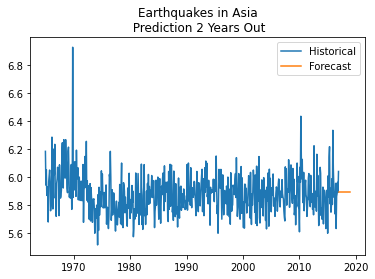

In [31]:
sari_mod = fit_mod(monthly_mean_asian,best_order)
forecast = sari_mod.forecast(steps=24)

fig, ax=plt.subplots()
ax.plot(monthly_mean_asian, label='Historical')
ax.plot(forecast, label='Forecast')
ax.set_title('Earthquakes in Asia\n Prediction 2 Years Out')
plt.legend();

In [32]:
print(sari_mod.summary())

                               SARIMAX Results                                
Dep. Variable:              Magnitude   No. Observations:                  624
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 355.488
Date:                Wed, 08 Dec 2021   AIC                           -706.975
Time:                        06:47:18   BIC                           -698.113
Sample:                    01-01-1965   HQIC                          -703.531
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9394      0.014    -66.439      0.000      -0.967      -0.912
sigma2         0.0186      0.001     28.706      0.000       0.017       0.020
Ljung-Box (L1) (Q):                   0.69   Jarque-

### SARIMAX - Introduction of eXogenous variables
Rather than look at results solely determined from the `Magnitude` target, I wanted to introduce other possible contributing factors that I hoped would make the analysis more complete.  These included `Latitude`, `Longitude` and `Depth`.

In [33]:
# Setting up the 3 new Time-Series.  These need to match the train in order for the comparison to work
monthly_lat = (pd.Series(df_asian.set_index(df_asian['Date_Time'])['Latitude'])).resample('MS').mean()
monthly_long = (pd.Series(df_asian.set_index(df_asian['Date_Time'])['Longitude'])).resample('MS').mean()
monthly_dep = (pd.Series(df_asian.set_index(df_asian['Date_Time'])['Depth'])).resample('MS').mean()

# Define the Exogenous Variables
exo_lat = monthly_lat[:cutoff]
exo_lat_test = monthly_lat[cutoff:]
exo_long = monthly_long[:cutoff]
exo_long_test = monthly_long[cutoff:]
exo_dep = monthly_dep[:cutoff]
exo_dep_test = monthly_dep[cutoff:]
exo_lat_long = exo_long
exo_lat_long_test = exo_long_test

# Set up Lists for making models and printing summaries

mod_list = ['Endo = Magnitude, Exo = Latitude:',
            'Endo = Magnitude, Exo = Longitude:',
            'Endo = Magnitude, Exo = Depth:',
            'Endo = Latitude, Exo = Longitude:']

mod_train_list = [exo_lat, exo_long, exo_dep, exo_lat_long]
mod_test_list = [exo_lat_test, exo_long_test, exo_dep_test, exo_lat_long_test]

endos = [train,train,train,exo_lat]

for mod in range(len(mod_list)):
    model = fit_mod(endos[mod],best_order,mod_train_list[mod])
#     print(model.summary()) # Commented out to save space - Critical info printed below
    print(mod_list[mod],'\np-values\n',round(model.pvalues,2),'\nAIC:',round(model.aic,3))
    print('Train RMSE:',round(RMSE(train,model),4),'\n','Test RMSE:',round(RMSE_test(test,model,mod_test_list[mod]),4),'\n')

Endo = Magnitude, Exo = Latitude: 
p-values
 Latitude    0.11
ma.L1       0.00
sigma2      0.00
dtype: float64 
AIC: -585.791
Train RMSE: 0.3066 
 Test RMSE: 0.1449 

Endo = Magnitude, Exo = Longitude: 
p-values
 Longitude    0.23
ma.L1        0.00
sigma2       0.00
dtype: float64 
AIC: -584.484
Train RMSE: 0.3104 
 Test RMSE: 0.144 

Endo = Magnitude, Exo = Depth: 
p-values
 Depth     0.42
ma.L1     0.00
sigma2    0.00
dtype: float64 
AIC: -583.715
Train RMSE: 0.3078 
 Test RMSE: 0.1458 

Endo = Latitude, Exo = Longitude: 
p-values
 Longitude    0.0
ma.L1        0.0
sigma2       0.0
dtype: float64 
AIC: 3467.129
Train RMSE: 15.5694 
 Test RMSE: 13.6124 



Because the associated p-values are all ≥ 0.05, this told me that all 3 (`Latitude`, `Longitude` and `Magnitude`) are not significntly associated with the `Magnitude` of the earthquakes investigated here, when looking at all of Asia.  When compared to each other, `Latitude` and `Longitude` are significantly associated, which intuitively makes sense, but didn't provide me with enough data to make any decisions.

### Combined Latitude and Longitude
It seemed plausible that the above p-values were above threshold, because that analysis looked at all of Asia.  It was reasonable to investigate whether a combination of `Latitude` and `Longitude`, as one variable, compared to `Magnitude` would provide as a better model.  To look into this, it was necessary to make train and test arrays of the two time-series and enter these into the SARIMAX model as a single exogenous variable.

In [34]:
# Make the 2 arrays
lat_long_array = np.array([[exo_lat][0],[exo_long][0]]).transpose()
lat_long_test_array = np.array([[exo_lat_test][0],[exo_long_test][0]]).transpose()

# Fit the new model
mod_magn_lat_long = fit_mod(train, best_order, lat_long_array)

# Model Summary:
# print(mod_magn_lat_long.summary()) # Commented out to save space - Shorter summary below
print('Endo = Magnitude, Exo = Latitude/Longitude Combo:','\np-values\n',round(mod_magn_lat_long.pvalues,2),
      '\n','AIC:',round(mod_magn_lat_long.aic,3))
print('Train RMSE:',round(RMSE(train,mod_magn_lat_long),4))
final_asia_test_rmse = round(RMSE_test(test,mod_magn_lat_long,lat_long_test_array),4)
print('Test RMSE:',final_asia_test_rmse)

Endo = Magnitude, Exo = Latitude/Longitude Combo: 
p-values
 x1        0.04
x2        0.06
ma.L1     0.00
sigma2    0.00
dtype: float64 
 AIC: -587.089
Train RMSE: 0.3111
Test RMSE: 0.1426


---
# Success!!  Final Model

### SARIMAX (0,1,1)x(0,0,0,12), Target = `Magnitude`, Latitude/Longitude Combo Array as Exogenous Variable
#### Fit with maxiter = 200 and fit method was Nelder-Mead to avoid code-processing errors
The p-value of "x1" (I believe this corresponds to the `Latitude` component of the tuple) is < 0.05, when `Latitude` and `Longitude` are compared as a single variable (tuple), meaning, these results are significant!  The AIC is the lowest of all the models thus far studied, with regards to this particular analysis.  While the train RMSE (0.3111) is more than double the test RMSE (0.1426), there isn't any evidence that the model is underfitting, so I will call this my Final Model.

In [35]:
print('Total Earthquakes in Asian Countries:',len(df_asian))
print('Overall Magnitude Mean:',round(df_countries['Magnitude'].mean(),3))
print('Overall Magnitude Standard Deviation:',round(df_countries['Magnitude'].std(),3))
print('Root Mean Squared Error (RMSE):',round(final_asia_test_rmse,3))

Total Earthquakes in Asian Countries: 8859
Overall Magnitude Mean: 5.883
Overall Magnitude Standard Deviation: 0.424
Root Mean Squared Error (RMSE): 0.143


---
## Time to look at Japan results
I wanted to see what happens when we zoom in on an area, hoping to find more useful results.  Since Japan has a disproportionately large amount of earthquakes, compared to the rest of the world, it was a natural first choice.

First I wrote and then imported a "Japan" module for all Japan-related investigations.  The quarterly time-series is returned when the module initializes.

In [36]:
# Import the python file that processes all the Japan data
from data import Japan

quarterly_mean_japan, df_japan = Japan.load()

Import Successful!


When investigating the monthly mean of Japan, I discovered that some months had no values.  This is because there didn't happen to be any earthquakes in Japan during those months of those years.  All rows need real numbers, so I changed from monthly to quarterly resampling and used a forward fill to fill in any missing values with the data just prior.  This isn't a perfect process, but it is a reasonably good one.

Train/test split process is similar to the larger Asian dataset.  However, the forward-filled data represent questionable results, as they aren't necessarily accurate for every quarter.  It is difficult to choose a train/test split that is balanced, when the test set is much smaller, and therefore, more affected by any missing data.  Fortunately, when inspecting results, it appeared that this had not adversely affected the process, so the cutoff remained at 80% of the quarterly mean.

In [37]:
cutoff = round(quarterly_mean_japan.shape[0] * 0.8)
train = quarterly_mean_japan[:cutoff]

Started with a Random Walk again for a baseline.

In [38]:
rw_japan_rmse = Japan.random_walk(train)
print('Japan Random Walk RMSE (Baseline):', round(rw_japan_rmse,3))

Japan Random Walk RMSE (Baseline): 0.204


The data for this Japan subset behave similarly to the all-asian data, so ACF and PACF analyses were not necessary.  Similarly as above, I calculated the optimized SARIMA parameters for the Japan dataset (one-time event), stored them into a dictionary, which was converted to a dataframe and saved as a new csv in the data folder.

In [39]:
# Japan.auto_ARIMA(train)

Loaded in and inspected the dictionary of SARIMA results for the Japan dataset.

In [40]:
japan_arima = pd.read_csv('data/SARIMAX_dict3.csv')
japan_arima.sort_values('aic').head(4)

,Unnamed: 0,stats,aic
108,108,"ARIMA(0, 1, 1)x(0, 0, 0, 4)",-143.543595
594,594,"ARIMA(2, 1, 1)x(0, 0, 0, 4)",-143.071985
270,270,"ARIMA(1, 0, 1)x(0, 0, 0, 4)",-142.429619
351,351,"ARIMA(1, 1, 1)x(0, 0, 0, 4)",-141.565428


As with the Asian time-series data, I acquired the exact same order of the four models with the lowest AIC scores - consistency is good.  However, when I investigated metrics from using the different hyperparameters, I discovered that the ARIMA values produced the best, most consistent results when set at (1,0,1).  Then I proceeded with the same steps performed with the Asian dataset.  As with the initial quarterly mean above, the `Latitude`, `Longitude`, and `Depth` time-series were all forward-filled as well.

In [41]:
best_order = (1,0,1)

Japan.generate_SARIMAX(df_japan,quarterly_mean_japan,best_order,cutoff)

Endo = Magnitude, Exo = Latitude/Longitude Combo: 
p-values 
 x1        0.0
x2        0.0
ar.L1     0.0
ma.L1     0.0
sigma2    0.0
dtype: float64 
 AIC: -97.295
Train RMSE: 0.1779
Test RMSE: 0.1885


As with the overall Asian monthly data, looking at `Magnitude`, factoring in the contributions, simultaneously, from `Latitude` and `Longitude` produced the best results.  The final statistics for quarterly Japanese earthquakes follow:

In [42]:
print('Total Earthquakes in Japan:',len(df_japan))
print('Overall Magnitude Mean:',round(df_japan['Magnitude'].mean(),3))
print('Overall Magnitude Standard Deviation:',round(df_japan['Magnitude'].std(),3))
print('Root Mean Squared Error (RMSE):',round(0.1885,3))

Total Earthquakes in Japan: 2102
Overall Magnitude Mean: 5.896
Overall Magnitude Standard Deviation: 0.426
Root Mean Squared Error (RMSE): 0.189
